In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 2906, done.
remote: Counting objects: 100% (516/516), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 2906 (delta 350), reused 485 (delta 332), pack-reused 2390
Receiving objects: 100% (2906/2906), 39.56 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (1845/1845), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
! pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.15
    Uninstalling polars-0.20.15:
      Successfully uninstalled polars-0.20.15


In [4]:
! pip install simsimd scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import (
    _preprocessing_history_trendiness_scores, 
    add_history_trendiness_scores_feature, 
    _preprocessing_mean_delay_features, 
    add_mean_delays_features, 
    _preprocessing_window_features, 
    add_window_features, 
    add_trendiness_feature_categories, 
    _preprocessing_article_endorsement_feature, 
    get_unique_categories,
    add_trendiness_feature
)

from catboost import CatBoostClassifier

2024-05-12 16:20:48.189103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 16:20:48.189268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 16:20:48.336606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Memory Utils

In [6]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8668


In [7]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [8]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.126


# Articles Preprocessing

In [9]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')),
    pl.col('topics').list.len().alias('num_topics'),
    (pl.col('total_pageviews') / pl.col('total_inviews')).alias('total_pageviews/inviews')
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 58.23 MB
Memory usage after optimization is: 58.00 MB
Decreased by 0.4%

RAM memory GB usage = 1.134


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null


In [10]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['MISC', 'PROD', 'LOC', 'ORG', 'EVENT', 'PER']

In [11]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{414: 'underholdning',
 572: 'side9',
 140: 'krimi',
 2504: 'bibliotek',
 539: 'ferie',
 2975: 'penge',
 2737: 'podcast',
 498: 'musik',
 2731: 'dagsorden',
 1505: 'vin',
 22: 'horoskoper',
 2341: 'plus',
 561: 'haandvaerkeren',
 457: 'forbrug',
 2889: 'auto',
 806: 'om_ekstra_bladet',
 2077: 'opinionen',
 731: 'services',
 142: 'sport',
 2: 'incoming',
 529: 'biler',
 118: 'nyheder',
 68: 'video',
 512: 'nationen',
 565: 'sex_og_samliv'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [12]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.145


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32]
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]"


In [14]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [15]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [16]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 26.9 s, sys: 0 ns, total: 26.9 s
Wall time: 26.9 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]","[0.143765, 0.287477, … 0.281061]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]","[0.108833, 0.350178, … 0.113327]"


In [17]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]",0.143765,0.287477,0.143963,0.143734,0.281061
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]",0.108833,0.350178,0.316195,0.111466,0.113327


# History preprocessing

In [18]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [19]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:13,  1.20it/s]                        



RAM memory GB usage = 1.301
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 16.3 s, sys: 1.52 s, total: 17.9 s
Wall time: 14 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,PRODPct,LOCPct,ORGPct,EVENTPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,1,16,"[0.016041, 0.062928, … 0.178427]",0.223776,0.237762,0.804196,0.888112,0.202797,0.874126
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.117424,0.318182,0.776515,0.852273,0.087121,0.787879


In [20]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [21]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [22]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [23]:
%cd /kaggle/working
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

/kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [24]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

/kaggle/working/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 171.41 column/sec. Elapsed time 4.26 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 39.62 sec. Users per second: 381


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [25]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.40 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 20.14 sec. Users per second: 751


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342628,0.345141,0.048661,0.261759,0.263204,0.670397,0.392258,0.085219,0.858655,1.275579,...,0.997953,0.856898,0.997953,0.001871,5.929536,0.95823,0.015104,0.463956,3.324192,0.009294


In [26]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 3min 13s, sys: 2min 3s, total: 5min 17s
Wall time: 1min 27s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
421318189,9770288,0.061934,0.185802,0.178832,0.032385,0.083668,0.092152
437061705,9776870,0.158929,0.595746,0.472341,0.290229,0.70046,0.836847
504444990,9020783,0.545948,0.319613,0.814947,0.475678,0.261493,0.584159
116722692,9772168,0.0,0.0,0.0,0.0,0.0,0.0
213568823,9432542,0.00106,0.002385,0.003893,0.0,0.0,0.0


In [27]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [28]:
def normalize_endorsement(articles_endorsement_raw):
    return articles_endorsement.sort(by='impression_time').with_columns(
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').sum().over('impression_time')
        ).alias('normalized_endorsement_10h'),
        (
            pl.col('endorsement_10h') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_10h_diff_rolling'),
        (
            pl.col('endorsement_10h').rolling_mean(5, min_periods=1).over('article') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_macd'),
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').quantile(0.8).over('impression_time')
        ).alias('endorsement_quantile_norm_10h')
    ).with_columns(
        (
            pl.col('normalized_endorsement_10h') / 
            pl.col('normalized_endorsement_10h').rolling_max(10, min_periods=1).over('impression_time')
        ).alias('normalized_endorsement_10h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [29]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_train, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_train)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_train, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_train, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

topics = articles.select("topics").explode("topics").unique()
topics = [topic for topic in topics["topics"] if topic is not None]

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours'),
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()

16it [00:26,  1.63s/it]                        
2427it [00:04, 520.52it/s]                          
16it [00:01,  9.06it/s]                        
16it [00:02,  7.61it/s]                        
100%|██████████| 506/506 [00:02<00:00, 171.61it/s]



RAM memory GB usage = 2.714
Memory usage of dataframe is 853.28 MB
Memory usage after optimization is: 535.17 MB
Decreased by 37.3%

RAM memory GB usage = 2.405
CPU times: user 9min 32s, sys: 39.8 s, total: 10min 11s
Wall time: 2min 58s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PROD_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32
306497592,9771523,777687,2023-05-18 16:20:32,0,2,17.0,null,false,2,null,false,1506473,5,104,327,648,4,16,0.318043,0.160494,0.634951,false,2023-05-18 14:14:15,142,0.7687,"""Neutral""",2,3,16,324,4,23813,203671,1.912246e6,0.116919,"""article_default""",0,2,false,false,true,true,true,true,0.137804,0.127127,0.196991,0.126707,0.153706,0.350703,271.027039,403.959595,2.014889,50.732357,0.0,1.675676,6,24,10,6,0,1,0,0,12,35,110,998,0.011125,21.5,12.1,0.498004,0.348464
323100293,9770882,493231,2023-05-18 09:13:55,0,1,204.0,null,false,2,null,false,973410,5,25,131,203,4,9,0.19084,0.123153,0.254369,false,2023-05-18 04:37:32,118,0.8683,"""Negative""",1,6,14,282,4,104202,547438,7.859722e6,0.190345,"""article_default""",0,4,false,false,true,true,false,true,0.95888,1.0,0.556627,1.0,1.0,0.878875,201.570251,184.012833,3.607758,89.122955,3.694215,92.413223,76,51,0,0,1,0,0,0,46,50,96,996,0.027974,18.799999,10.2,1.014257,0.668008
448128452,9142581,453157,2023-05-22 04:19:44,0,2,15.0,100.0,false,2,null,false,879744,5,86,246,388,1,4,0.349593,0.221649,0.449726,true,2022-03-09 08:02:34,414,0.6342,"""Positive""",8,5,27,961,7,null,null,null,null,"""article_default""",438,10532,false,true,false,true,false,true,0.010303,0.01779,0.007643,0.008786,0.015375,0.00646,263.2547,239.893585,35.839005,863.724182,7.396875,179.665619,161,301,145,167,0,0,0,1,22,114,45,499,0.006486,-27.0,-17.0,0.358993,0.815359
335489370,8315213,1182750,2023-05-20 05:58:01,0,1,122.0,null,false,2,null,false,190399,5,14,28,54,6,5,0.5,0.259259,0.055446,true,2020-10-09 18:04:48,565,0.9296,"""Neutral""",4,3,16,774,2,null,null,null,null,"""article_default""",952,22859,true,true,true,false,false,true,0.060705,0.346226,0.605208,0.126528,0.384839,0.771593,303.234161,191.472092,84.034439,2022.176392,13.919512,339.417084,309,60,12,127,1,0,0,1,2,52,0,66,0.00084,7.4,4.0,0.048423,0.134694
86747819,9773673,970808,2023-05-23 20:17:14,0,2,12.0,100.0,false,2,null,false,422559,5,33,98,168,2,20,0.336735,0.196429,0.166102,false,2023-05-20 14:21:05,118,0.8961,"""Negative""",2,4,22,223,4,174892,720605,5.127488e6,0.242702,"""article_default""",3,77,false,false,true,true,false,true,0.59246,0.459303,0.449572,0.735803,0.658968,0.743789,192.166672,186.503128,16.708607,403.749084,0.055556,4.555555,7,6,6,3,0,0,1,0,0,0,108,35,0.000503,5.6,3.0,0.024718,0.015264


In [30]:
train_ds.shape

(2585747, 74)

## Session Features

In [31]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [32]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.371
CPU times: user 1.92 s, sys: 269 ms, total: 2.19 s
Wall time: 1.53 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
174779,2023-05-16 09:26:07,0,[9767302],0.0
1054838,2023-05-17 05:41:43,0,[9768566],0.0


In [33]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 2.737


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
306497592,9771523,777687,2023-05-18 16:20:32,0,2,17.0,null,false,2,null,false,5,104,327,648,4,16,0.318043,0.160494,0.634951,false,142,0.7687,"""Neutral""",2,3,16,324,4,23813,203671,1.912246e6,0.116919,"""article_default""",0,2,…,true,true,true,0.137804,0.127127,0.196991,0.126707,0.153706,0.350703,271.027039,403.959595,2.014889,50.732357,0.0,1.675676,6,24,10,6,0,1,0,0,12,35,110,998,0.011125,21.5,12.1,0.498004,0.348464,0,0.0,9,false,false
323100293,9770882,493231,2023-05-18 09:13:55,0,1,204.0,null,false,2,null,false,5,25,131,203,4,9,0.19084,0.123153,0.254369,false,118,0.8683,"""Negative""",1,6,14,282,4,104202,547438,7.859722e6,0.190345,"""article_default""",0,4,…,true,false,true,0.95888,1.0,0.556627,1.0,1.0,0.878875,201.570251,184.012833,3.607758,89.122955,3.694215,92.413223,76,51,0,0,1,0,0,0,46,50,96,996,0.027974,18.799999,10.2,1.014257,0.668008,0,3.363636,-118,true,false


In [34]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.55954,0.023985


In [35]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [36]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 575.55 MB
Memory usage after optimization is: 523.46 MB
Decreased by 9.1%

RAM memory GB usage = 2.607
CPU times: user 2.16 s, sys: 1.32 s, total: 3.48 s
Wall time: 3.01 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
306497592,9771523,777687,2023-05-17,0,2,17.0,null,false,2,null,false,5,104,327,648,4,16,0.318043,0.160494,0.634951,false,142,0.7687,"""Neutral""",2,3,16,324,4,23813,203671,1.912246e6,0.116919,"""article_default""",0,2,…,true,true,0.137804,0.127127,0.196991,0.126707,0.153706,0.350703,271.027039,403.959595,2.014889,50.732357,0.0,1.675676,6,24,10,6,0,1,0,0,12,35,110,998,0.011125,21.5,12.1,0.498004,0.348464,0,0.0,9,false,false,0.301587
323100293,9770882,493231,2023-05-17,0,1,204.0,null,false,2,null,false,5,25,131,203,4,9,0.19084,0.123153,0.254369,false,118,0.8683,"""Negative""",1,6,14,282,4,104202,547438,7.859722e6,0.190345,"""article_default""",0,4,…,false,true,0.95888,1.0,0.556627,1.0,1.0,0.878875,201.570251,184.012833,3.607758,89.122955,3.694215,92.413223,76,51,0,0,1,0,0,0,46,50,96,996,0.027974,18.799999,10.2,1.014257,0.668008,0,3.363636,-118,true,false,0.222222


# Adding history features

In [37]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

259it [35:15,  8.17s/it]


Memory usage of dataframe is 1574.88 MB
Memory usage after optimization is: 1192.66 MB
Decreased by 24.3%

RAM memory GB usage = 5.378


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,MISCPct,PRODPct,LOCPct,ORGPct,EVENTPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_underholdning_Pct,Category_side9_Pct,Category_krimi_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_penge_Pct,Category_podcast_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_vin_Pct,Category_horoskoper_Pct,Category_plus_Pct,Category_haandvaerkeren_Pct,Category_forbrug_Pct,Category_auto_Pct,Category_om_ekstra_bladet_Pct,Category_opinionen_Pct,Category_services_Pct,Category_sport_Pct,Category_incoming_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
18147211,9768308,1078673,0,1,254.0,100.0,false,2,null,false,5,48,201,325,5,12,0.238806,0.147692,0.326829,true,118,0.8182,"""Negative""",4,4,22,970,3,97563,851515,5.0044e6,0.114576,"""article_default""",1,25,false,…,1,11,0.074713,0.224138,0.574713,0.873563,0.097701,0.752874,0.507766,true,6,0.971264,0.178161,0.0,0.310345,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063218,0.0,0.0,0.356322,0.0,0.074713,0.0
307424320,9770989,436524,0,2,29.0,null,false,2,null,false,5,46,105,152,4,11,0.438095,0.302632,0.203883,false,140,0.9948,"""Negative""",3,7,13,141,2,101707,460662,3.551386e6,0.220784,"""article_default""",0,5,false,…,1,19,0.210762,0.233184,0.753363,0.941704,0.107623,0.865471,0.144751,false,8,0.96861,0.089686,0.0,0.116592,0.0,0.0,0.008969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013453,0.0,0.0,0.0,0.0,0.071749,0.0,0.0,0.578475,0.008969,0.112108,0.0


In [38]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d', 'total_read_time'
]
RANK_IMPRESSION_DESCENDING = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'total_pageviews', 'total_read_time',
    'total_inviews', 'trendiness_score_category', 'trendiness_score_5d'
]
RANK_IMPRESSION_ASCENDING = [
    'article_delay_hours', 'std_JS', 'mean_topics_mean_delay_hours'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
LIST_DIVERSITY = [
    'category', 'sentiment_label', 'article_type'
]

train_ds = train_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).rank(method='min').over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_ASCENDING],
    *[pl.col(c).rank(method='min', descending=True).over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_DESCENDING],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).entropy().over(pl.col('impression_id')).alias(f'entropy_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('impression_id'))).alias(f'{c}_minus_median_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
    *[pl.col(c).n_unique().over('impression_id').alias(f'{c}_diversity_impression')
      for c in LIST_DIVERSITY],
)

# Training

In [39]:
# subsample dataset

behaviors_subsample = behaviors_train.select(['impression_id','user_id','article_ids_inview','article_ids_clicked']) \
    .pipe(
        sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
    ).explode('article_ids_inview').drop('article_ids_clicked').rename({'article_ids_inview' : 'article'}) \
    .with_columns(pl.col('user_id').cast(pl.UInt32), pl.col('article').cast(pl.Int32)) \
    .select(['impression_id', 'user_id', 'article'])

train_ds = behaviors_subsample.join(train_ds, on=['impression_id','user_id','article'], how='left')
train_ds.head()

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,…,entropy_impression_endorsement_10h,entropy_impression_total_pageviews/inviews,entropy_impression_mean_JS,entropy_impression_mean_topic_model_cosine,entropy_impression_topics_cosine,entropy_impression_article_delay_hours,entropy_impression_total_pageviews,entropy_impression_total_inviews,entropy_impression_trendiness_score_category,entropy_impression_std_JS,entropy_impression_trendiness_score_5d,entropy_impression_total_read_time,trendiness_score_3d_minus_median_impression,endorsement_10h_minus_median_impression,total_pageviews/inviews_minus_median_impression,mean_JS_minus_median_impression,mean_topic_model_cosine_minus_median_impression,topics_cosine_minus_median_impression,article_delay_hours_minus_median_impression,total_pageviews_minus_median_impression,total_inviews_minus_median_impression,trendiness_score_category_minus_median_impression,std_JS_minus_median_impression,trendiness_score_5d_minus_median_impression,total_read_time_minus_median_impression,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article,category_diversity_impression,sentiment_label_diversity_impression,article_type_diversity_impression
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,…,f64,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f64,f64,f32,f32,f32,f32,f64,f64,f64,f64,f32,f64,f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,u32,u32,u32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,5,150,521,836,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,22415,220247,1.004828e6,0.101772,"""article_default""",0,0,false,…,1.622597,1.726481,1.747889,1.788327,1.689578,NaN,1.613433,1.737743,1.612282,1.739272,1.676222,1.558951,281.5,-873.5,-0.111306,-0.005177,0.030401,-0.02667,-1.0,-62463.5,-165503.0,4.0,-0.033664,447.5,-4.981345e6,0.447581,0.403328,0.884626,0.36119,0.0,0.233531,0.335164,0.897201,0.301919,4,3,1
149474,139836,9778669,0,2,13.0,null,false,2,null,false,5,85,199,313,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,74491,373488,4.365609e6,0.199447,"""article_default""",0,1,false,…,1.622597,1.726481,1.747889,1.788327,1.689578,NaN,1.613433,1.737743,1.612282,1.739272,1.676222,1.558951,-40.5,179.5,-0.013631,0.003967,-0.086817,0.015762,0.0,-10387.5,-12262.0,0.0,0.028015,-75.5,-1.620564e6,0.501163,0.632488,0.749907,0.437299,0.043478,0.266627,0.511387,0.837824,0.319083,4,3,1
149474,139836,9778657,1,2,13.0,null,false,2,null,false,5,45,117,183,3,7,0.384615,0.245902,0.197635,false,118,0.8347,"""Neutral""",2,6,31,336,3,108389,478098,7.606737e6,0.226709,"""article_default""",0,1,true,…,1.622597,1.726481,1.747889,1.788327,1.689578,NaN,1.613433,1.737743,1.612282,1.739272,1.676222,1.558951,-122.5,368.5,0.013631,0.05309,-0.030401,0.218611,0.0,23510.5,92348.0,0.0,0.051035,-205.5,1.620564e6,0.78901,0.718014,0.814746,0.801144,0.066667,0.350947,0.730242,0.874905,0.604487,4,3,1
150528,143471,9778682,0,2,25.0,null,false,2,null,false,5,69,206,334,3,7,0.334951,0.206587,0.347973,false,498,0.9546,"""Negative""",1,5,20,267,3,143520,455723,9.298546e6,0.314928,"""article_default""",0,1,false,…,1.712983,2.137333,2.093172,2.193873,2.100994,NaN,2.063931,2.158165,1.924178,2.126514,1.946778,2.008479,7.0,204.0,0.088219,0.013219,0.019437,-0.001332,1.0

In [40]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'article_type', 'postcode']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [41]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 5.985


In [42]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, rsm=0.7, subsample=0.5)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.169254
0:	learn: 0.6483375	total: 1.16s	remaining: 19m 18s
25:	learn: 0.5170990	total: 26.4s	remaining: 16m 29s
50:	learn: 0.5004466	total: 52.1s	remaining: 16m 8s
75:	learn: 0.4909700	total: 1m 17s	remaining: 15m 38s
100:	learn: 0.4829838	total: 1m 42s	remaining: 15m 9s
125:	learn: 0.4769364	total: 2m 7s	remaining: 14m 42s
150:	learn: 0.4719970	total: 2m 32s	remaining: 14m 20s
175:	learn: 0.4678952	total: 2m 58s	remaining: 13m 56s
200:	learn: 0.4643246	total: 3m 23s	remaining: 13m 27s
225:	learn: 0.4608256	total: 3m 47s	remaining: 13m
250:	learn: 0.4577382	total: 4m 12s	remaining: 12m 34s
275:	learn: 0.4549395	total: 4m 38s	remaining: 12m 9s
300:	learn: 0.4525963	total: 5m 2s	remaining: 11m 43s
325:	learn: 0.4500541	total: 5m 28s	remaining: 11m 19s
350:	learn: 0.4477669	total: 5m 53s	remaining: 10m 53s
375:	learn: 0.4457404	total: 6m 34s	remaining: 10m 54s
400:	learn: 0.4436238	total: 6m 58s	remaining: 10m 25s
425:	learn: 0.4417111	total: 7m 24s	remaining: 9m 58

In [43]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 11 s, sys: 490 ms, total: 11.5 s
Wall time: 11.4 s


Text(0.5, 1.0, 'Catboost Feature Importances')

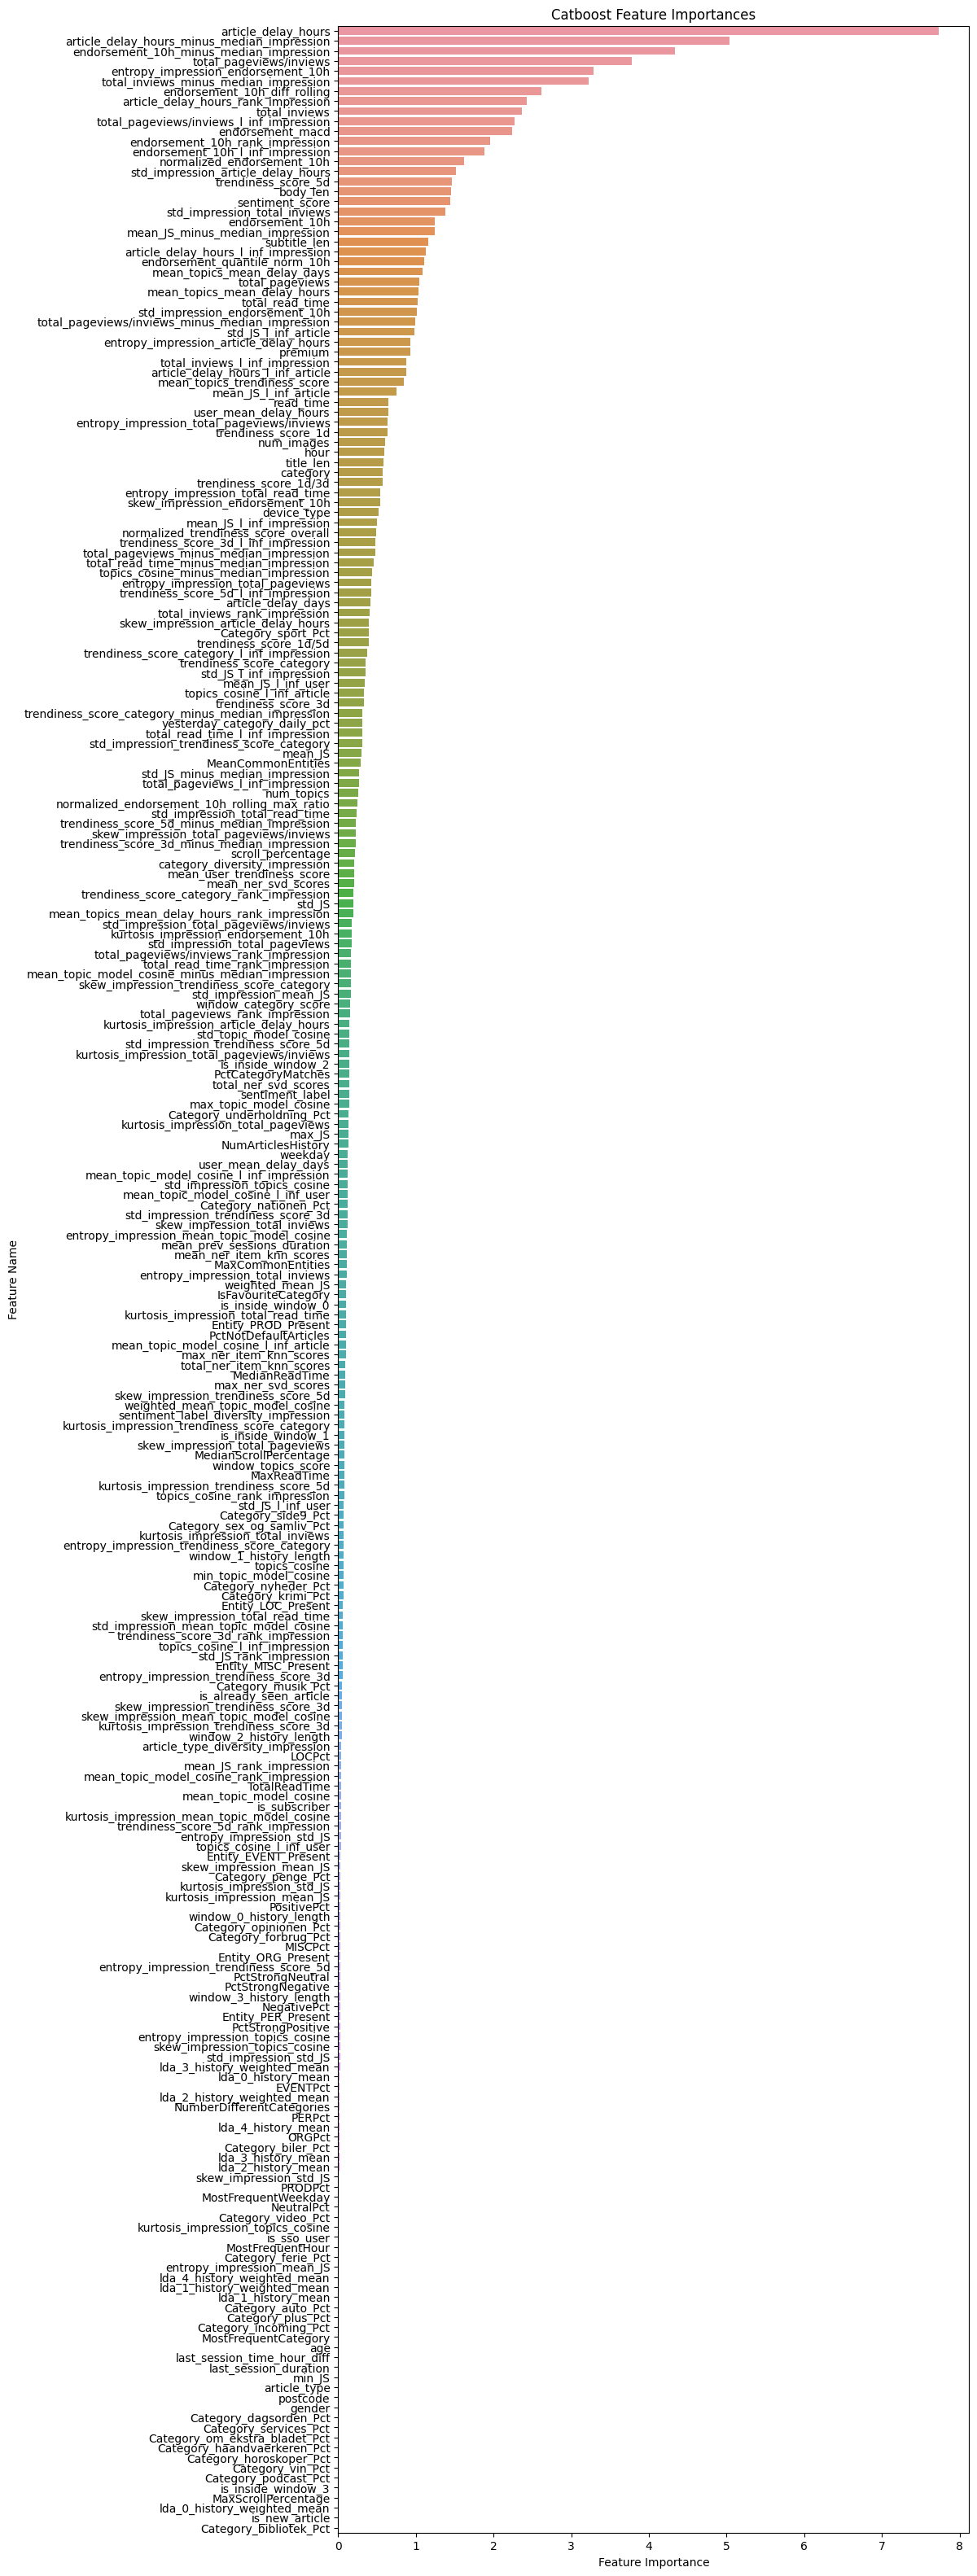

In [44]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 40))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [45]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 6.735


# Model Evaluation

In [46]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [47]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 176.47 column/sec. Elapsed time 4.13 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 42.05 sec. Users per second: 364


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [48]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.43 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 22.40 sec. Users per second: 683


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283615,0.285707,0.695447,0.415659,0.089191,0.876486,1.342637,...,0.997914,0.874658,0.997914,0.001527,5.728555,0.954883,0.012263,0.448203,3.536612,0.010003


In [49]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l_inf normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 3min 26s, sys: 2min 10s, total: 5min 36s
Wall time: 1min 33s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
93477830,9788471,0.038306,0.017712,0.056602,0.023992,0.01205,0.037313
377988434,9788168,0.086268,0.170778,0.158711,0.094536,0.185192,0.166217
444469423,9781057,0.34104,0.120354,0.288146,0.397818,0.152832,0.314728
151791321,9788048,0.002708,0.001909,0.004191,0.008397,0.006324,0.014034
156561858,9787465,0.06861,0.082746,0.086662,0.044877,0.058071,0.068755


In [50]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:12,  1.27it/s]                        



RAM memory GB usage = 7.422
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 15.6 s, sys: 1.16 s, total: 16.8 s
Wall time: 13.3 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,MISCPct,PRODPct,LOCPct,ORGPct,EVENTPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.266667,0.213333,0.846667,0.913333,0.3,0.893333
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,7,7,"[0.0, 0.048524, … 0.217846]",0.192982,0.254386,0.815789,0.947368,0.114035,0.807018


In [51]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [52]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_val, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_val)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_val, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_val, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .with_columns(pl.col('postcode').fill_null(5)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 
                            'total_pageviews/inviews', 'article_type']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

16it [00:23,  1.47s/it]                        
2205it [00:04, 511.30it/s]                          
16it [00:01,  9.12it/s]                        
16it [00:01,  8.66it/s]                        
100%|██████████| 507/507 [00:03<00:00, 148.97it/s]



RAM memory GB usage = 8.829
Memory usage of dataframe is 1012.26 MB
Memory usage after optimization is: 592.92 MB
Decreased by 41.4%

RAM memory GB usage = 8.406
CPU times: user 10min 29s, sys: 48.2 s, total: 11min 18s
Wall time: 3min 20s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,…,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
181080113,9777858,144669,2023-05-24,0,1,19.0,null,false,2,null,false,5,139,429,735,4,10,0.324009,0.189116,0.785714,false,142,0.6774,"""Positive""",4,5,23,404,4,31425,320869,1.380084e6,0.097937,"""article_default""",0,0,…,false,true,0.030506,0.028089,0.058496,0.019055,0.018529,0.056698,259.019226,377.759338,4.558668,111.860611,0.0,1.019231,102,7,0,20,1,0,0,0,38,136,112,663,0.011937,61.200001,32.799999,0.703822,0.405505,0,0.0,-118,true,false,0.239437
234593203,9779779,734909,2023-05-24,0,2,39.0,100.0,false,2,null,false,5,91,297,516,4,11,0.306397,0.176357,0.543956,false,142,0.5768,"""Neutral""",1,7,15,391,4,25913,270586,1.311562e6,0.095766,"""article_default""",0,0,…,false,true,0.103677,0.144349,0.150912,0.052725,0.059284,0.059883,194.147064,381.63382,2.492477,62.045677,12.823529,310.382355,18,7,2,9,1,0,0,0,1,3,112,419,0.011842,45.0,23.200001,0.294035,0.345425,9,5.5,-90,true,false,0.239437
143299554,9482970,1341614,2023-05-24,0,1,6.0,null,false,2,null,false,5,50,134,196,4,20,0.373134,0.255102,0.245421,true,118,0.9633,"""Negative""",6,6,23,1009,3,null,null,null,null,"""article_default""",211,5074,…,true,true,0.403524,0.300582,0.34856,0.383177,0.292989,0.267173,238.882019,184.884491,3.739159,92.23494,3.162921,77.483147,96,61,33,29,0,0,1,0,11,8,109,715,0.009961,-0.7,-0.9,0.481157,0.466102,0,0.25,-59,true,false,0.239437
376214739,9777983,533662,2023-05-30,0,2,56.0,null,false,2,null,false,5,27,75,123,3,20,0.36,0.219512,0.123762,false,414,0.8666,"""Positive""",0,7,20,89,2,31364,3889163,1.754761e6,0.008064,"""article_native""",2,61,…,false,true,0.0,0.0,0.0,0.0,0.0,0.0,182.940094,262.506805,12.021604,291.404327,3.877112,96.041473,288,197,118,169,0,0,1,0,18,28,41,3058,0.023237,5.0,-0.2,1.384337,0.698971,0,2.0,60,true,true,0.116788
499134805,9783990,1448650,2023-05-26,0,2,123.0,100.0,false,2,null,false,5,104,303,545,6,13,0.343234,0.190826,0.587209,false,142,0.6874,"""Positive""",2,6,15,268,4,113926,376854,6.396715e6,0.302308,"""article_default""",0,0,…,false,true,-0.008505,-0.006356,0.060974,0.053572,0.04302,0.079155,188.614288,396.226898,2.796335,69.457573,4.757143,118.328575,8,54,3,5,0,1,0,0,3,8,102,50,0.000509,21.333334,4.733333,0.027337,0.01224,0,16.0,93,false,false,0.302326


In [53]:
val_ds.shape

(2928942, 78)

In [54]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [34:35,  7.08s/it]


Memory usage of dataframe is 1783.90 MB
Memory usage after optimization is: 1350.94 MB
Decreased by 24.3%

RAM memory GB usage = 11.3


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_type,article_delay_days,article_delay_hours,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,MISCPct,PRODPct,LOCPct,ORGPct,EVENTPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_underholdning_Pct,Category_side9_Pct,Category_krimi_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_penge_Pct,Category_podcast_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_vin_Pct,Category_horoskoper_Pct,Category_plus_Pct,Category_haandvaerkeren_Pct,Category_forbrug_Pct,Category_auto_Pct,Category_om_ekstra_bladet_Pct,Category_opinionen_Pct,Category_services_Pct,Category_sport_Pct,Category_incoming_Pct,Category_biler_Pct,Category_nyheder_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,str,i16,i32,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
321178931,9788095,2029929,0,1,69.0,100.0,true,2,null,false,5,41,107,308,2,12,0.383178,0.133117,0.169572,false,140,0.9654,"""Negative""",1,10,16,289,5,34262,228099,1.868226e6,0.150207,"""article_default""",0,3,true,…,2,6,0.318612,0.252366,0.77918,0.861199,0.312303,0.807571,0.193492,false,10,0.971609,0.126183,0.0,0.138801,0.0,0.018927,0.063091,0.0,0.044164,0.0,0.0,0.0,0.0,0.0,0.015773,0.0,0.0,0.0,0.0,0.315457,0.0,0.0,0.236593,0.0,0.009464,0.031546
159931410,9789018,1043197,0,1,37.0,null,false,2,null,false,5,69,208,351,3,5,0.331731,0.196581,0.343234,false,414,0.8199,"""Positive""",1,3,9,214,4,71829,361225,2.148582e6,0.198848,"""article_default""",0,0,false,…,1,11,0.181287,0.28655,0.777778,0.923977,0.169591,0.853801,0.272369,false,9,0.953216,0.140351,0.0,0.239766,0.0,0.0,0.052632,0.0,0.023392,0.0,0.0,0.0,0.0,0.0,0.023392,0.0,0.0,0.005848,0.0,0.181287,0.0,0.0,0.292398,0.0,0.040936,0.0
309552193,9783296,1000956,1,1,12.0,null,false,2,null,false,5,31,120,165,5,19,0.258333,0.187879,0.245902,false,140,0.974,"""Negative""",1,8,17,158,2,76777,387211,4.002875e6,0.198282,"""article_default""",0,0,false,…,3,10,0.23913,0.338768,0.811594,0.942029,0.231884,0.880435,0.177691,false,10,0.983696,0.148551,0.0,0.106884,0.0,0.001812,0.030797,0.0,0.025362,0.0,0.0,0.0,0.0,0.0,0.023551,0.0,0.0,0.0,0.0,0.155797,0.0,0.001812,0.463768,0.0,0.041667,0.0
351480476,9783137,2202363,1,2,13.0,null,false,2,null,false,5,52,149,265,6,5,0.348993,0.196226,0.28876,false,512,0.7512,"""Negative""",3,6,24,196,2,71841,492379,4.306751e6,0.145906,"""article_default""",0,8,true,…,2,11,0.132325,0.26276,0.748582,0.931947,0.117202,0.824197,0.081644,false,9,0.984877,0.136106,0.0,0.281664,0.0,0.0,0.039698,0.0,0.011342,0.0,0.0,0.0,0.0,0.0,0.018904,0.0,0.0,0.00189,0.0,0.05293,0.0,0.0,0.359168,0.0,0.098299,0.0
88261316,9780302,310588,0,1,48.0,null,false,2,null,false,5,50,134,196,4,9,0.373134,0.255102,0.245421,false,118,0.8715,"""Neutral""",1,10,16,310,3,61696,303666,3.364859e6,0.203171,"""article_default""",0,2,false,…,3,22,0.225806,0.287097,0.780645,0.890323,0.177419,0.922581,0.562347,true,9,0.974194,0.103226,0.0,0.170968,0.0,0.003226,0.045161,0.0,0.003226,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,0.13871,0.0,0.0,0.467742,0.0,0.051613,0.0


In [55]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d', 'total_read_time'
]
RANK_IMPRESSION_DESCENDING = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'total_pageviews', 'total_read_time',
    'total_inviews', 'trendiness_score_category', 'trendiness_score_5d'
]
RANK_IMPRESSION_ASCENDING = [
    'article_delay_hours', 'std_JS', 'mean_topics_mean_delay_hours'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
LIST_DIVERSITY = [
    'category', 'sentiment_label', 'article_type'
]

val_ds = val_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).rank(method='min').over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_ASCENDING],
    *[pl.col(c).rank(method='min', descending=True).over(pl.col('impression_id')).alias(f'{c}_rank_impression')
      for c in RANK_IMPRESSION_DESCENDING],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).entropy().over(pl.col('impression_id')).alias(f'entropy_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('impression_id'))).alias(f'{c}_minus_median_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
    *[pl.col(c).n_unique().over('impression_id').alias(f'{c}_diversity_impression')
      for c in LIST_DIVERSITY],
)

In [56]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [57]:
val_ds.shape

(2928942, 254)

In [58]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'article_type',
 'postcode',
 'Entity_MISC_Present',
 'Entity_PROD_Present',
 'Entity_LOC_Present',
 'Entity_ORG_Present',
 'Entity_EVENT_Present',
 'Entity_PER_Present']

In [59]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
321178931,0,0.244265
159931410,0,0.066167
309552193,1,0.158142
351480476,1,0.281115
88261316,0,0.492996
…,…,…
229575603,0,0.007199
205365017,0,0.330792
62685926,0,0.098435


In [60]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
252264186,"[0, 0, … 0]","[0.042431, 0.292275, … 0.519743]"
462393613,"[0, 0, … 0]","[0.008114, 0.259652, … 0.35251]"
152446292,"[0, 0, … 1]","[0.025099, 0.014671, … 0.389622]"
76033121,"[0, 0, … 0]","[0.000717, 0.069223, … 0.49334]"
44452385,"[0, 0, … 0]","[0.288239, 0.536464, … 0.684037]"
…,…,…
327067808,"[0, 0, … 0]","[0.040431, 0.494767, … 0.180906]"
261376096,"[0, 0, … 0]","[0.403786, 0.014372, … 0.085276]"
242687079,"[0, 0, … 0]","[0.787111, 0.147003, … 0.3002]"


In [61]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 6min 50s, sys: 424 ms, total: 6min 50s
Wall time: 6min 50s


<MetricEvaluator class>: 
 {
    "auc": 0.7863058196185682,
    "mrr": 0.5683027123355535,
    "ndcg@5": 0.6343883631216356,
    "ndcg@10": 0.6632665495781781
}